In [1]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
#from sklearn.datasets import make_classification

import pandas as pd
from pandas import set_option
import time
import numpy as np
from numpy import mean
from numpy import std
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # plotting library for Python
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import pyodbc
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import warnings
warnings.filterwarnings('ignore')
import scipy as sp

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,  GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

In [5]:
#Load data
df = pd.read_csv('diabetic_data.csv')
pd.options.display.max_columns = 50
print('There are ', len(df), ' instances in the dataset and ', (len(df.columns)) , 'attributes.', '\n')
display(df.head())

There are  101766  instances in the dataset and  50 attributes. 



,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
#Load mapping document

mp = pd.read_csv('Readmission_IDs_mapping.csv')
pd.options.display.max_rows = 80
print('The mapping document has codes & descriptions for ',mp.Variable.unique())
mp.head(80)

The mapping document has codes & descriptions for  ['admission_type' 'discharge_disposition' 'admission_source']


,Variable,Id,description
0,admission_type,1,Emergency
1,admission_type,2,Urgent
2,admission_type,3,Elective
3,admission_type,4,Newborn
4,admission_type,5,Not Available
5,admission_type,6,NaN
6,admission_type,7,Trauma Center
7,admission_type,8,Not Mapped
8,discharge_disposition,1,Discharged to home
9,discharge_disposition,2,Discharged/transferred to another short term h...


In [9]:
#View the summary of the df columns, data types, and non-null values
display(df.info())                      # check for total records,  nulls, and data types of each attribute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

None

UNIVARIATE ANALYSIS

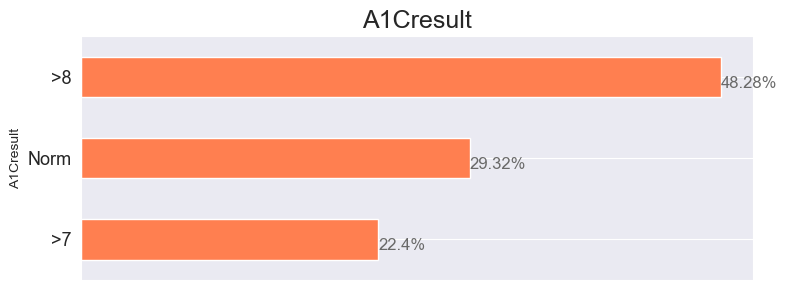

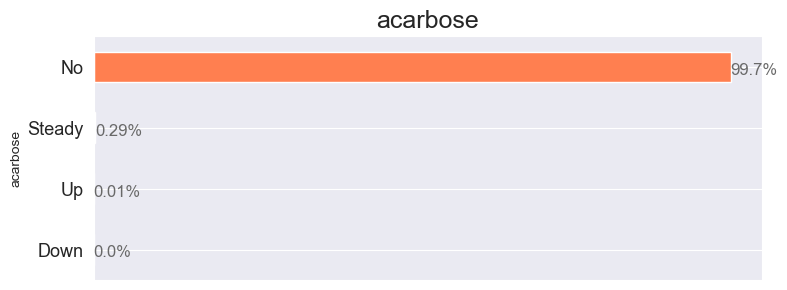

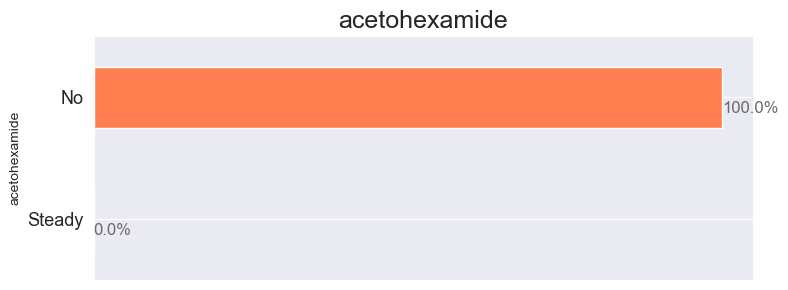

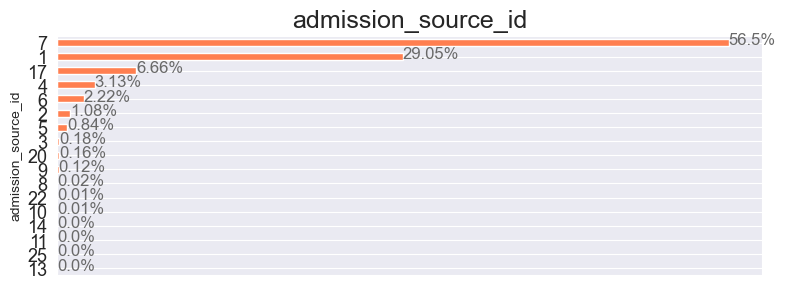

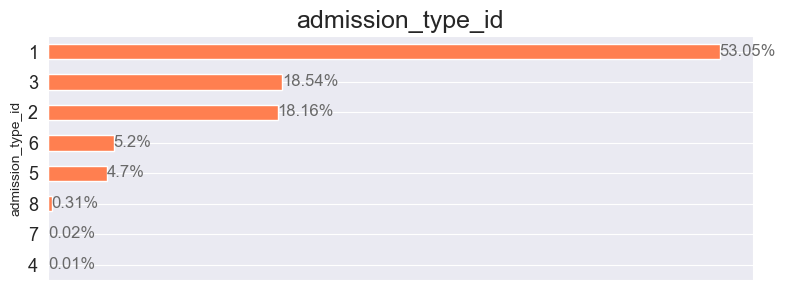

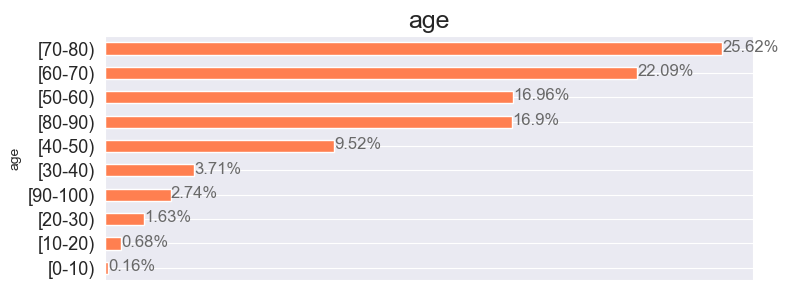

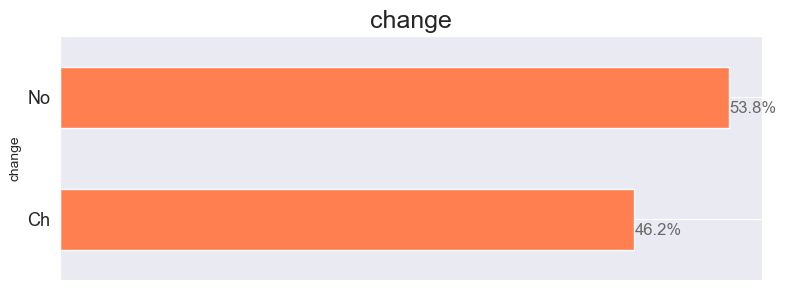

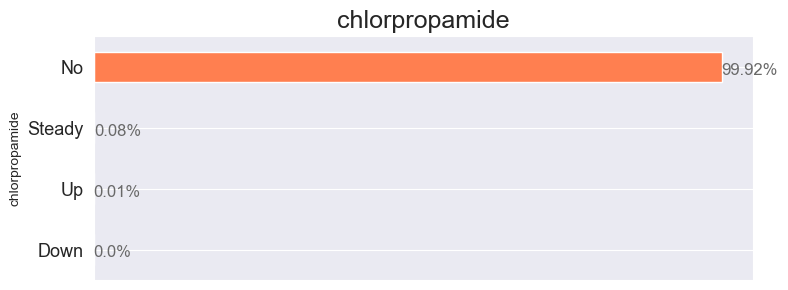

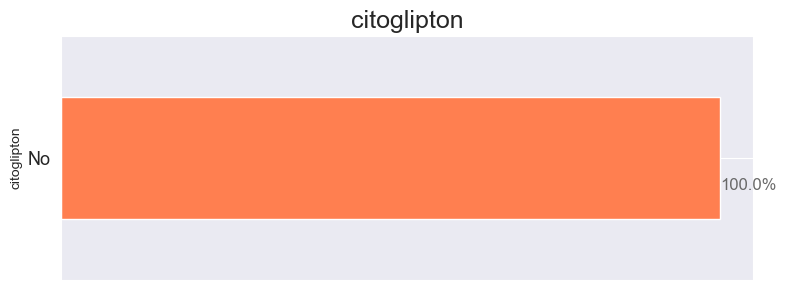

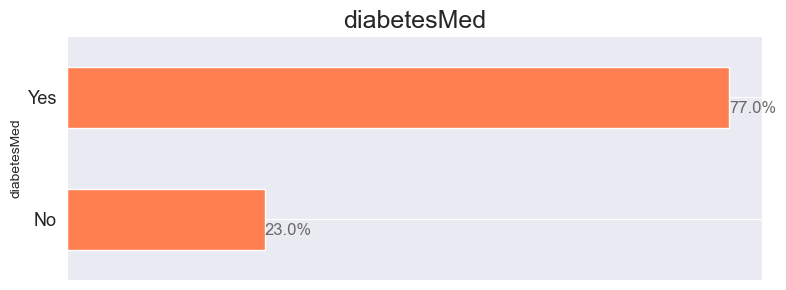

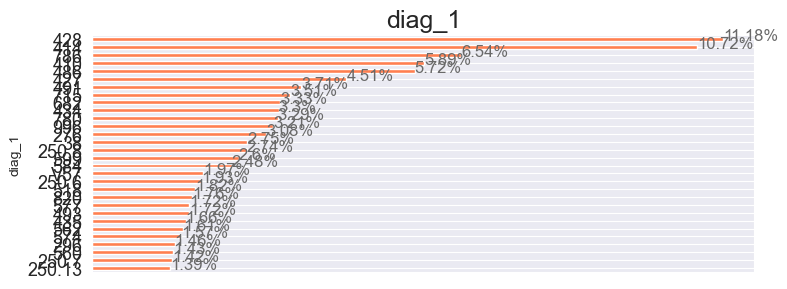

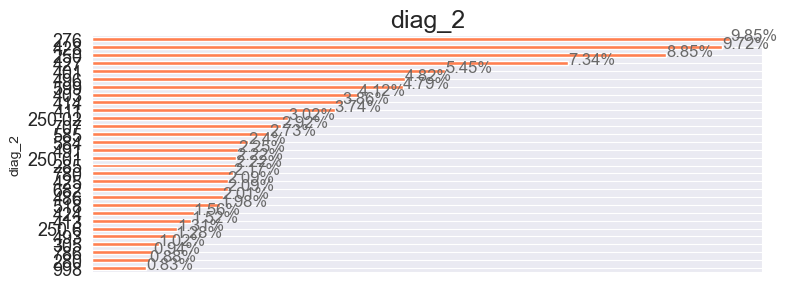

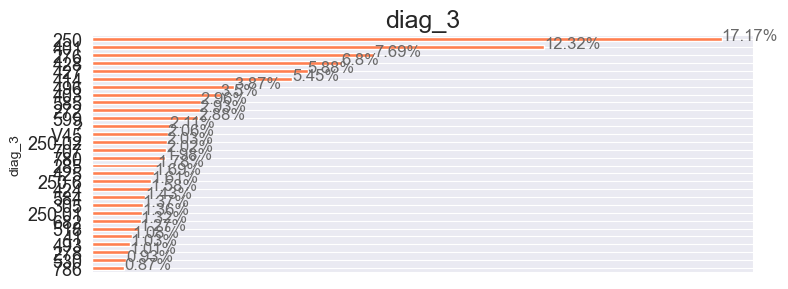

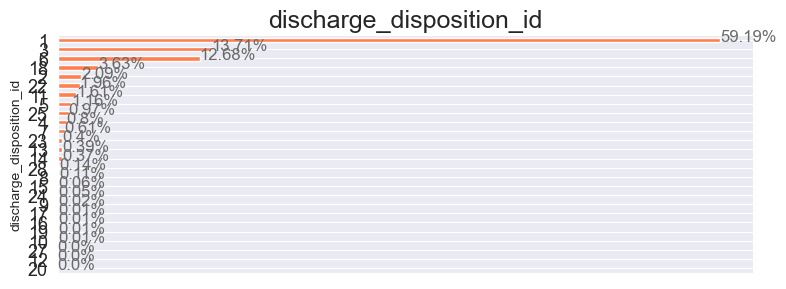

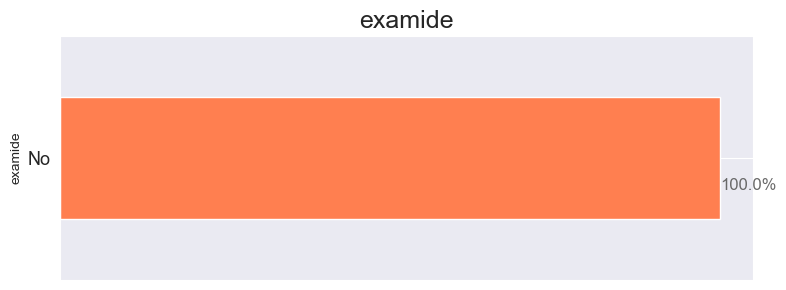

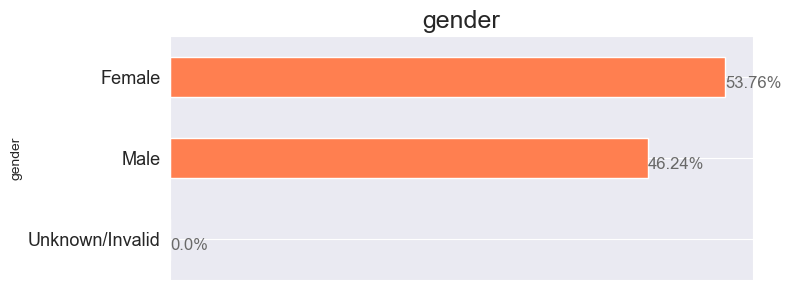

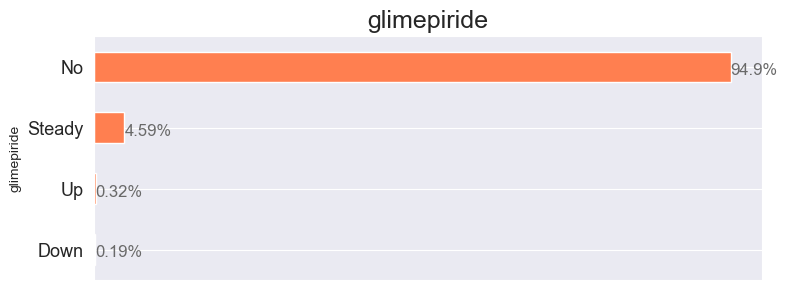

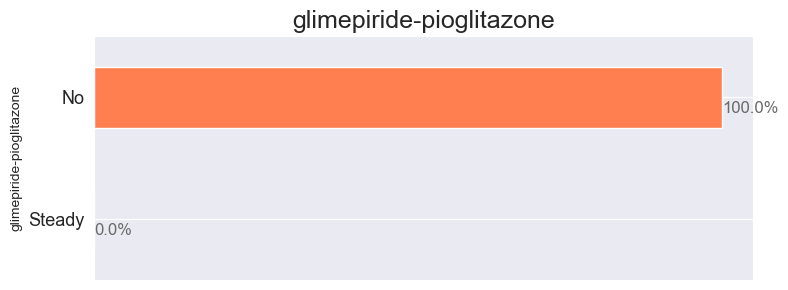

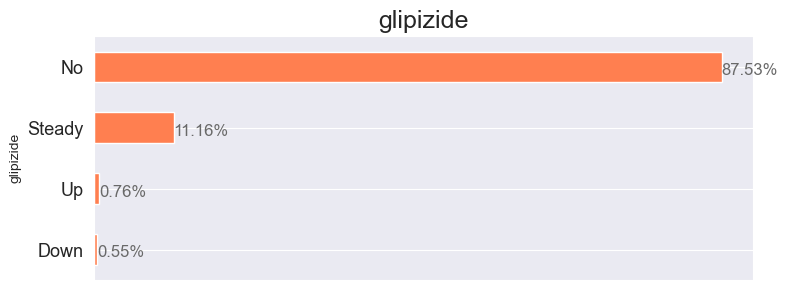

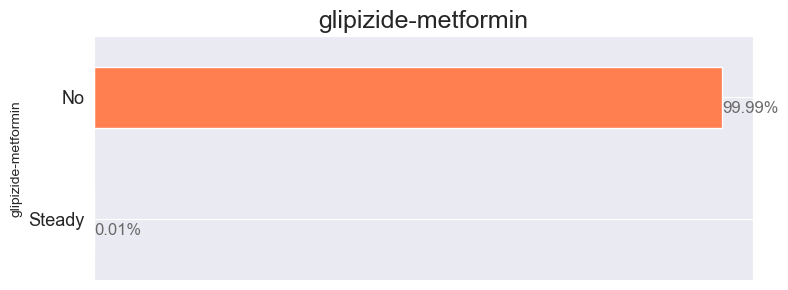

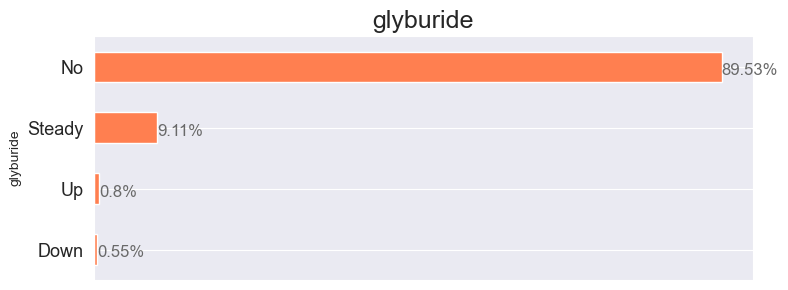

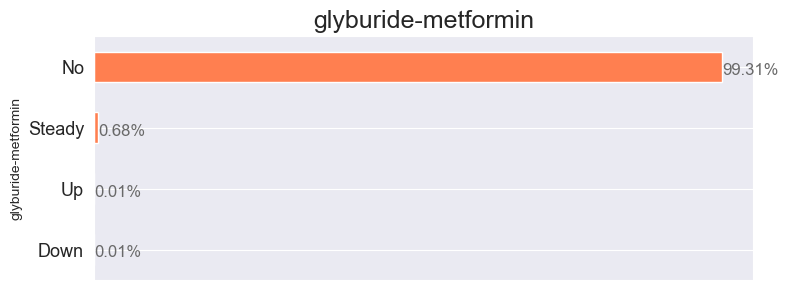

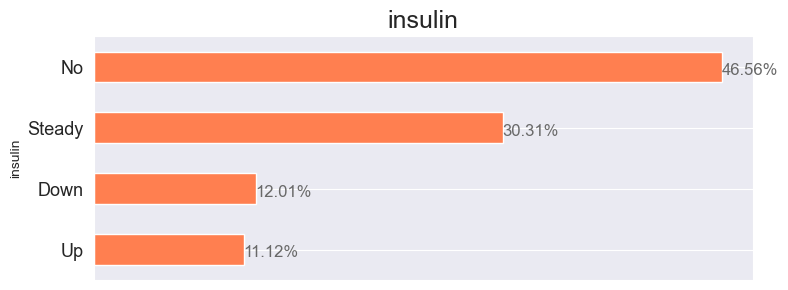

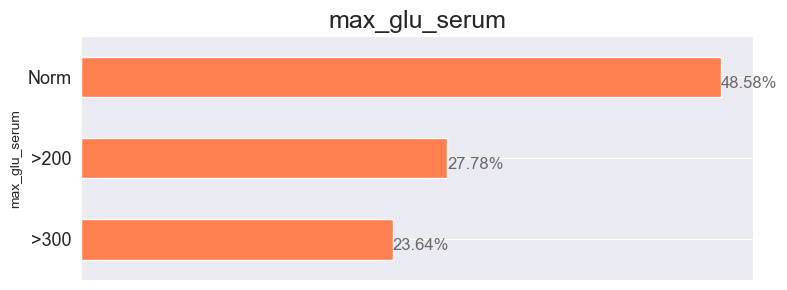

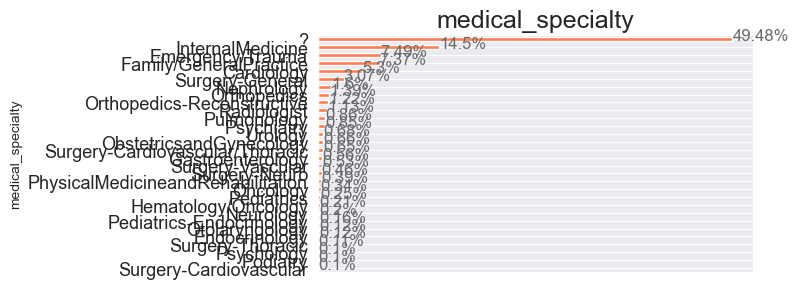

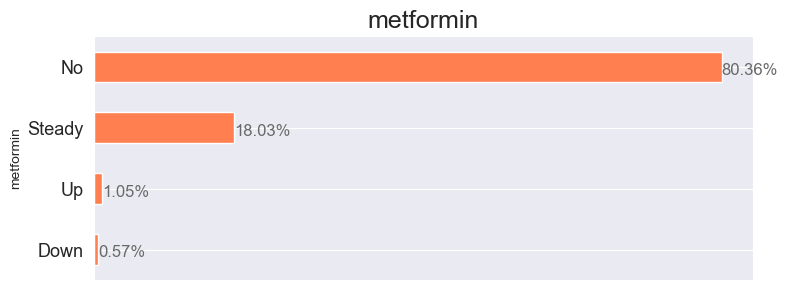

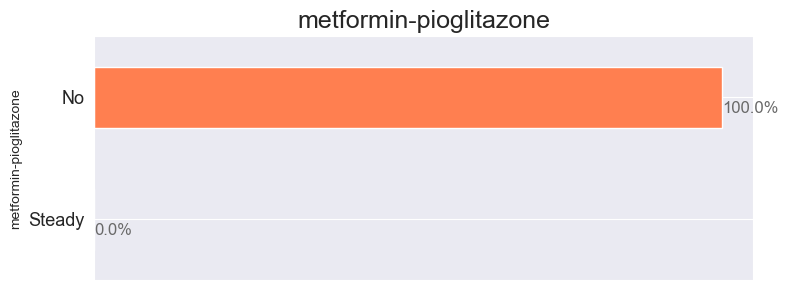

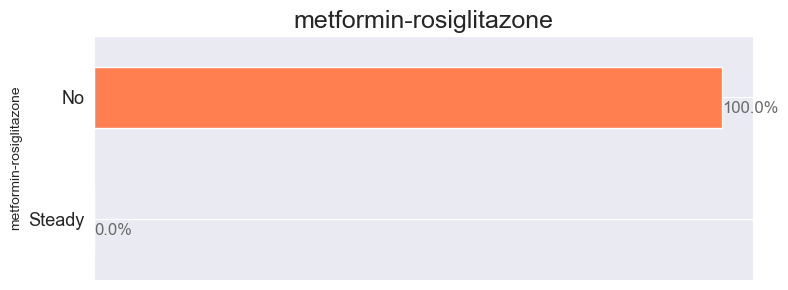

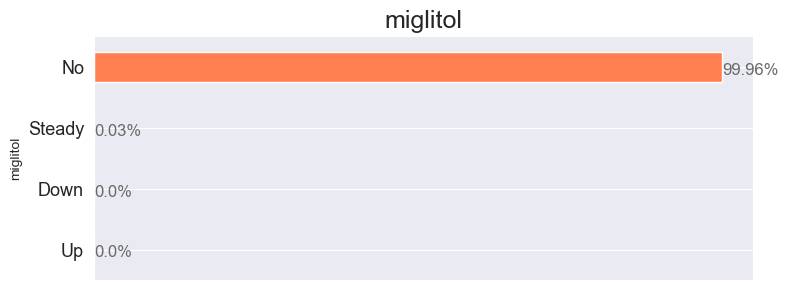

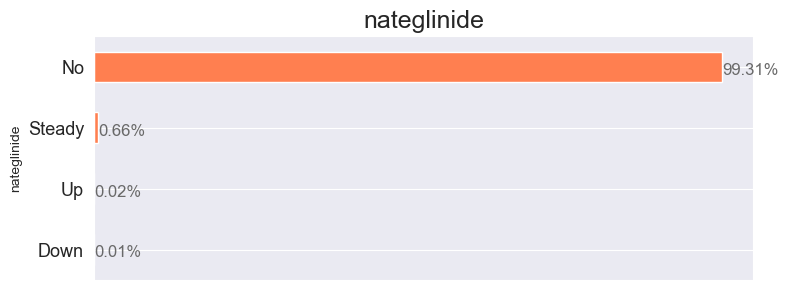

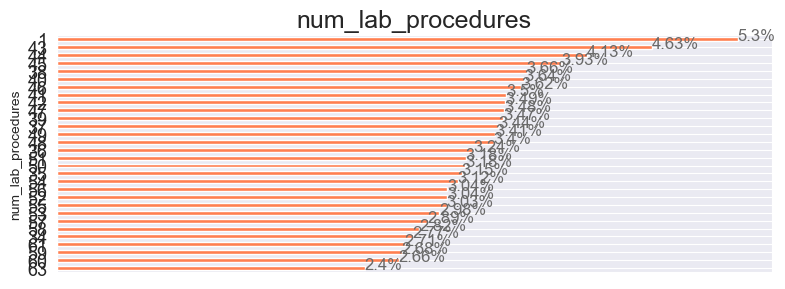

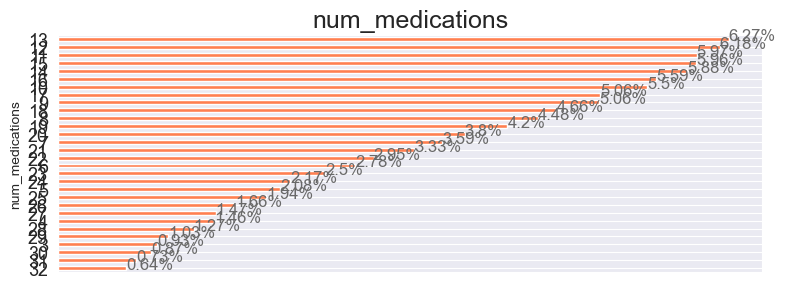

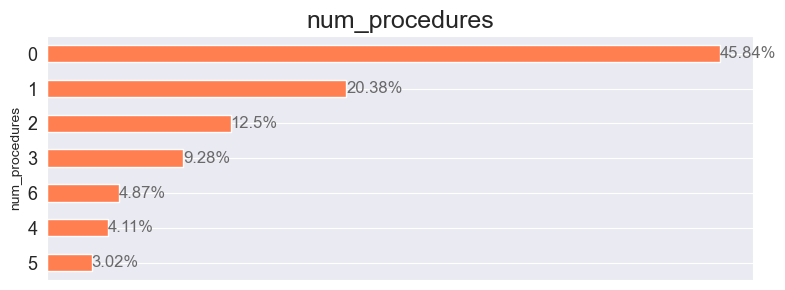

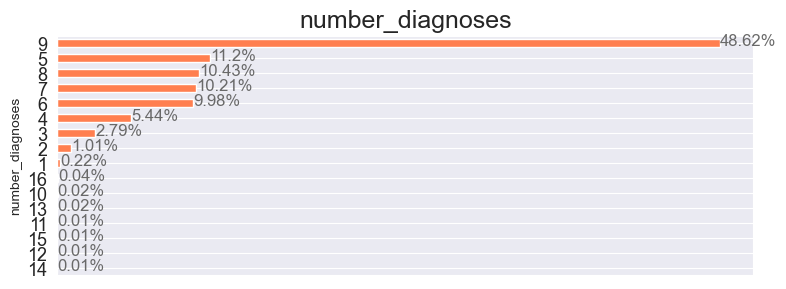

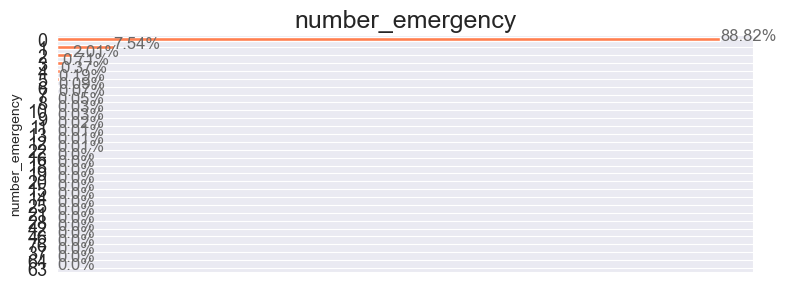

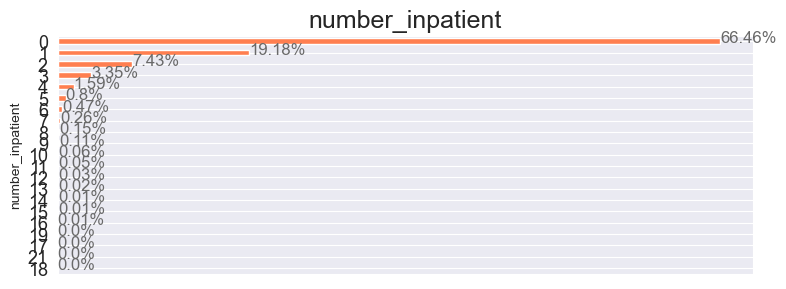

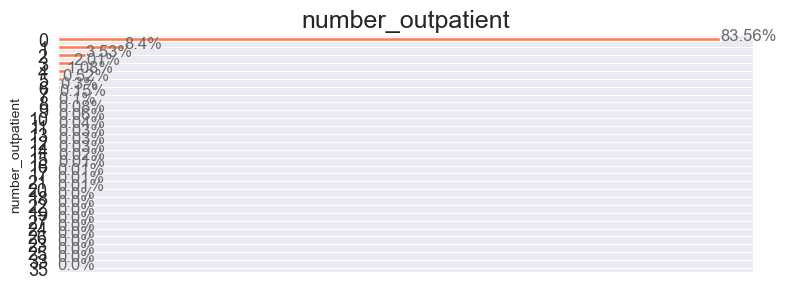

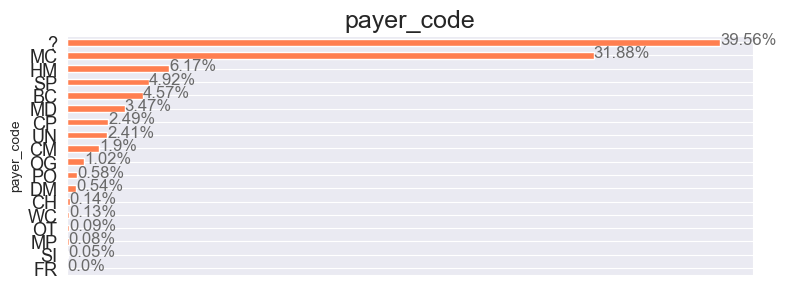

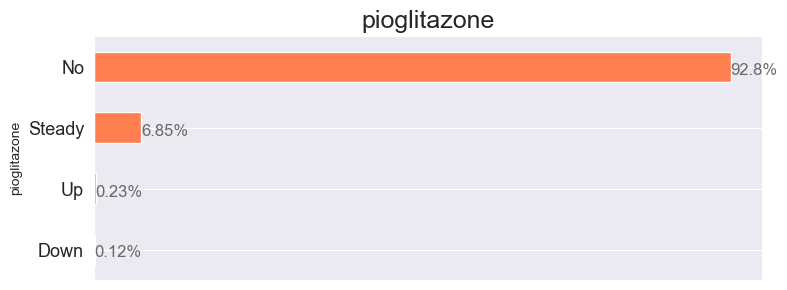

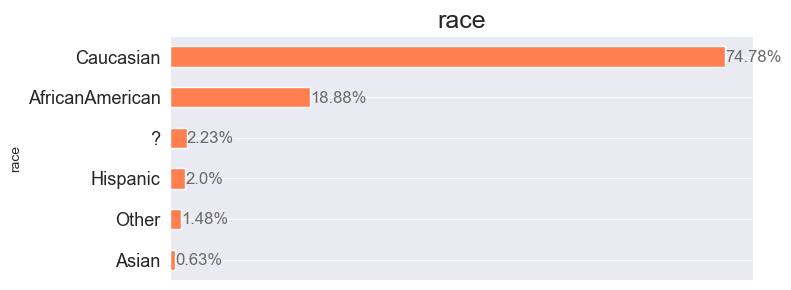

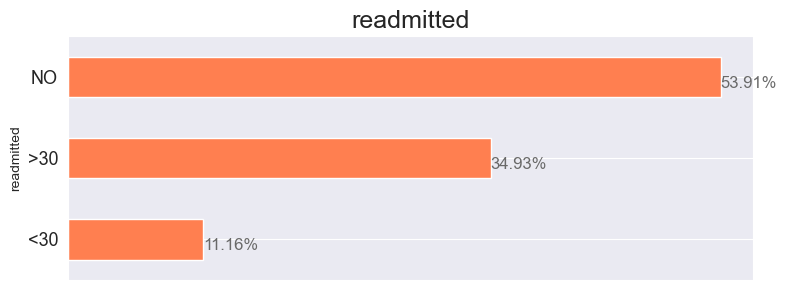

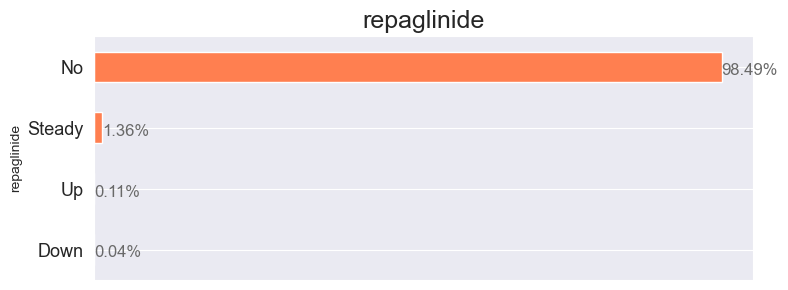

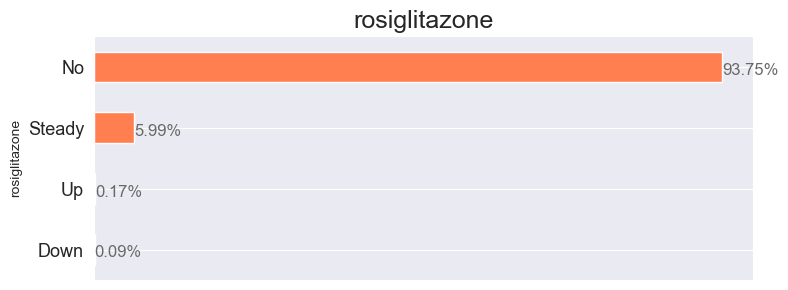

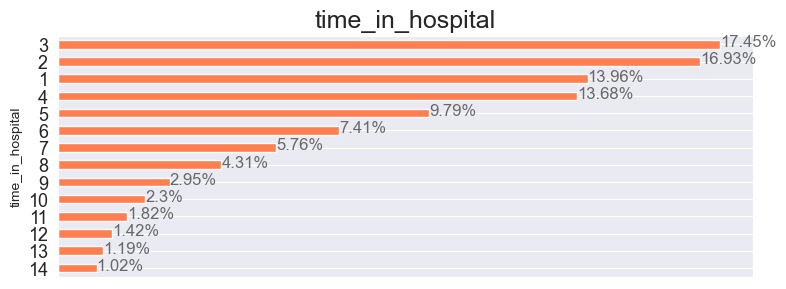

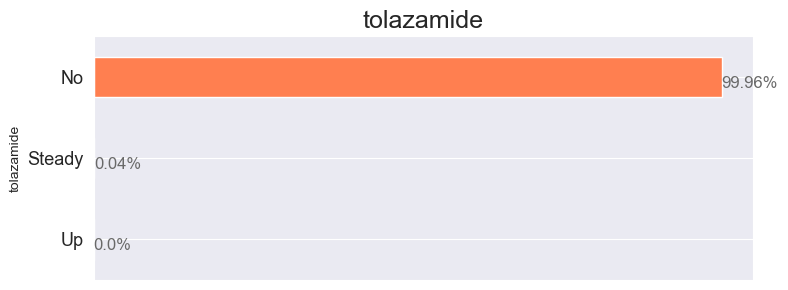

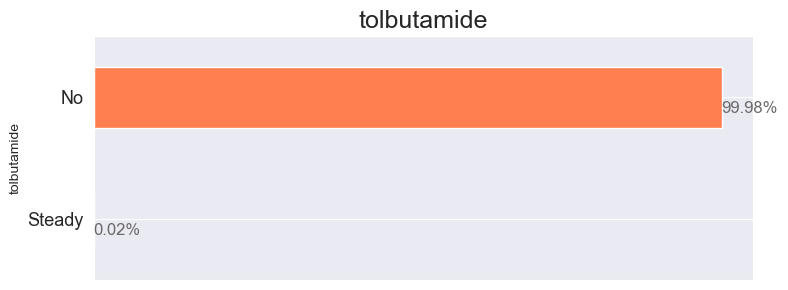

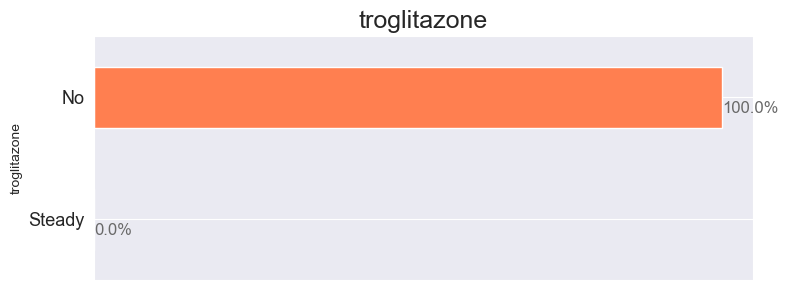

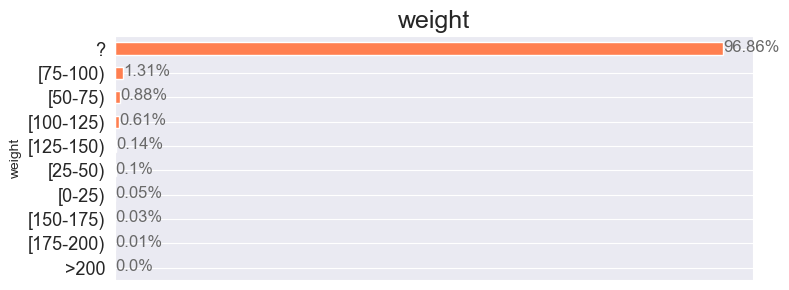

In [12]:
#Inspect value counts for each attribute
for col in df[df.columns.difference(['encounter_id', 'patient_nbr'])]:

    ax = df[col].value_counts().head(30).plot(kind='barh', figsize=(8,3),
                                            color="coral", fontsize=13);
    ax.set_alpha(0.8)
    ax.set_title(col, fontsize=18)
    #ax.set_xlabel("%s: %f " % ([col]),fontsize=18);
   
    ax.set_xticks([])

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(round((i.get_width()/total)*100, 2))+'%', fontsize=12,
    color='dimgrey')

    # invert for largest on top 
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show();
    

In [13]:
#preview the unique values from each column 
for col in df[df.columns.difference(['encounter_id', 'patient_nbr'])]:
    try:     
        print('\n',"-- %s --" % col,'\n',df[col].unique()[:30]) #if unique values are > 30
    except:
        print('\n',"-- %s --" % col,'\n',df[col].unique())


 -- A1Cresult -- 
 [nan '>7' '>8' 'Norm']

 -- acarbose -- 
 ['No' 'Steady' 'Up' 'Down']

 -- acetohexamide -- 
 ['No' 'Steady']

 -- admission_source_id -- 
 [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]

 -- admission_type_id -- 
 [6 1 2 3 4 5 8 7]

 -- age -- 
 ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

 -- change -- 
 ['No' 'Ch']

 -- chlorpropamide -- 
 ['No' 'Steady' 'Down' 'Up']

 -- citoglipton -- 
 ['No']

 -- diabetesMed -- 
 ['No' 'Yes']

 -- diag_1 -- 
 ['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' '737' '572' 'V57' '189' '786' '427' '996'
 '277' '584' '462' '473' '411' '174' '486']

 -- diag_2 -- 
 ['?' '250.01' '250' '250.43' '157' '411' '492' '427' '198' '403' '288'
 '998' '507' '174' '425' '456' '401' '715' '496' '428' '585' '250.02'
 '410' '999' '996' '135' '244' '41' '571' '276']

 -- diag_3 -- 
 ['?' '255' 'V27' '403' '250' 'V45' '38' '486' '996

Relative Frequencies of Readmissions 
 readmitted
NO     0.54
>30    0.35
<30    0.11
Name: proportion, dtype: float64


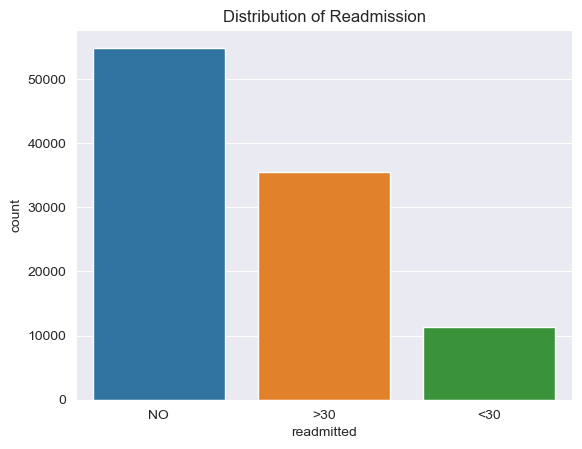

In [16]:
# The readmitted class distribution is our target variable. It tells us if a patient was hospitalized within 30 days, greater than 30 days or not readmitted.
print('Relative Frequencies of Readmissions','\n' , np.round(df['readmitted'].value_counts(normalize=True), decimals=2))
# Distribution of Readmission 

sns.countplot(x=df['readmitted']).set_title('Distribution of Readmission')

#Target(Outcome) Variable - prepare for binary classification
df.replace({'readmitted': {'NO': 0, '>30': 0, '<30': 1 }}, inplace=True)

In [18]:
# check values that are coded as "?" -missing values
column = []
cntcol = []
for col in df.columns:
    if df[col].dtype == object:
        column.append(col)
        cntcol.append(df[col][df[col] == '?'].count())
coln = pd.DataFrame({'Col': column, 'Count': cntcol})
coln[coln.Count != 0]

,Col,Count
0,race,2273
3,weight,98569
4,payer_code,40256
5,medical_specialty,49949
6,diag_1,21
7,diag_2,358
8,diag_3,1423


In [20]:
#Generate descriptive statistics excluding the first 2 columns
np.round(df.describe(), decimals=2)
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [22]:
# Generate descriptive statistics and round to 2 decimal places
descriptive_stats = np.round(df.describe(), decimals=2)

# Alternatively, you can use display to show it (in Jupyter Notebooks)
display(descriptive_stats)

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,1.017660e+05,1.017660e+05,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00
mean,1.652016e+08,5.433040e+07,2.02,3.72,5.75,4.40,43.10,1.34,16.02,0.37,0.20,0.64,7.42,0.11
std,1.026403e+08,3.869636e+07,1.45,5.28,4.06,2.99,19.67,1.71,8.13,1.27,0.93,1.26,1.93,0.31
min,1.252200e+04,1.350000e+02,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
25%,8.496119e+07,2.341322e+07,1.00,1.00,1.00,2.00,31.00,0.00,10.00,0.00,0.00,0.00,6.00,0.00
50%,1.523890e+08,4.550514e+07,1.00,1.00,7.00,4.00,44.00,1.00,15.00,0.00,0.00,0.00,8.00,0.00
75%,2.302709e+08,8.754595e+07,3.00,4.00,7.00,6.00,57.00,2.00,20.00,0.00,0.00,1.00,9.00,0.00
max,4.438672e+08,1.895026e+08,8.00,28.00,25.00,14.00,132.00,6.00,81.00,42.00,76.00,21.00,16.00,1.00


BIVARIATE ANALYSIS

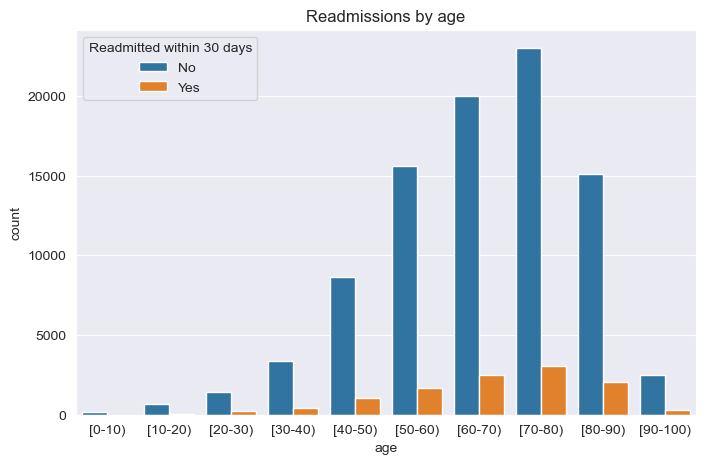

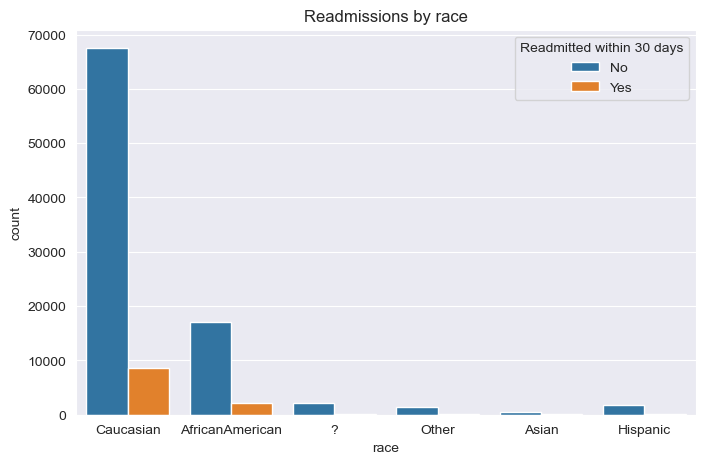

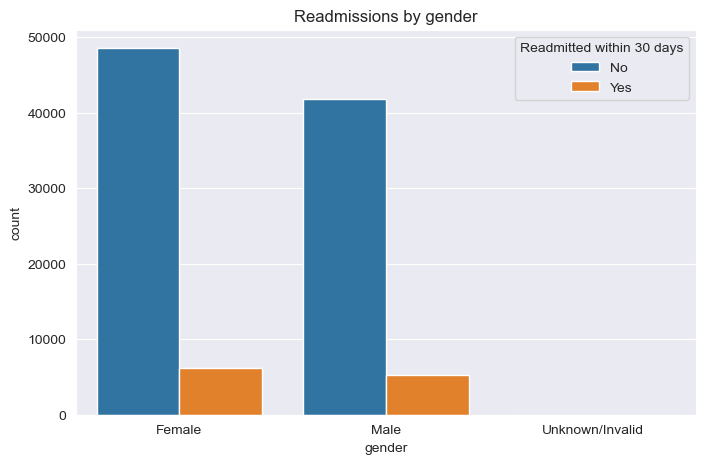

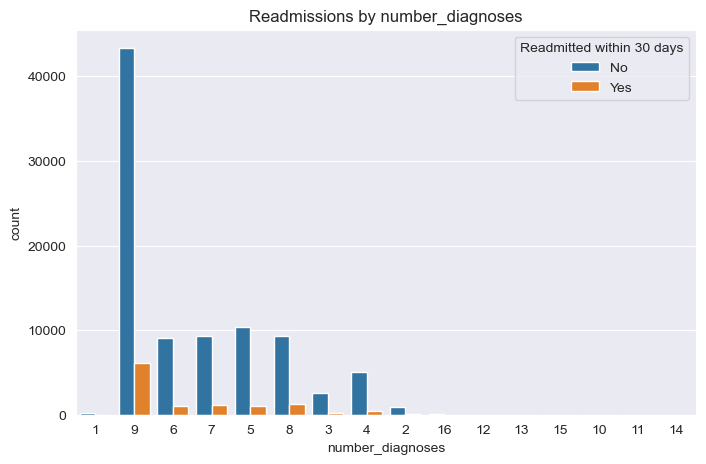

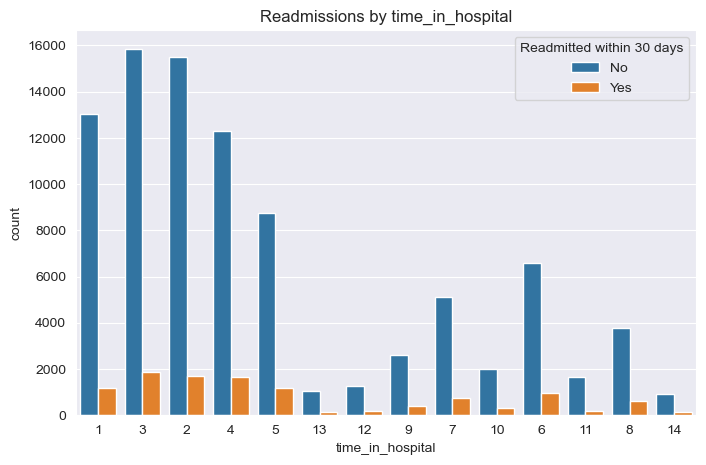

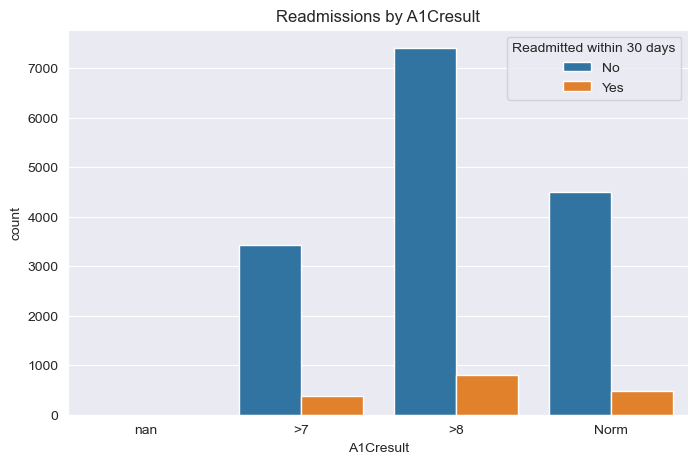

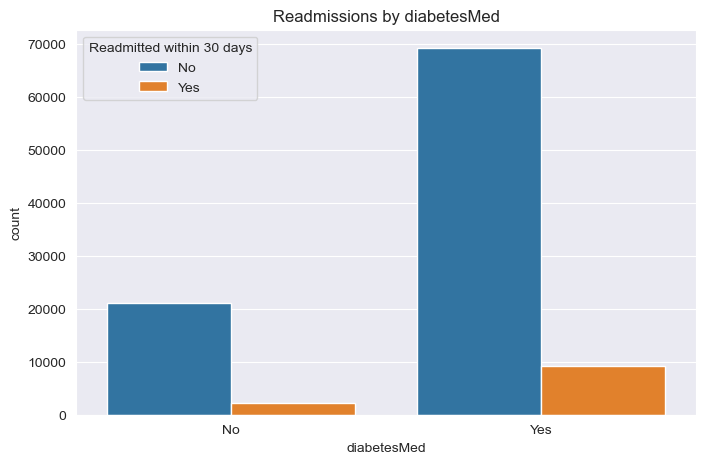

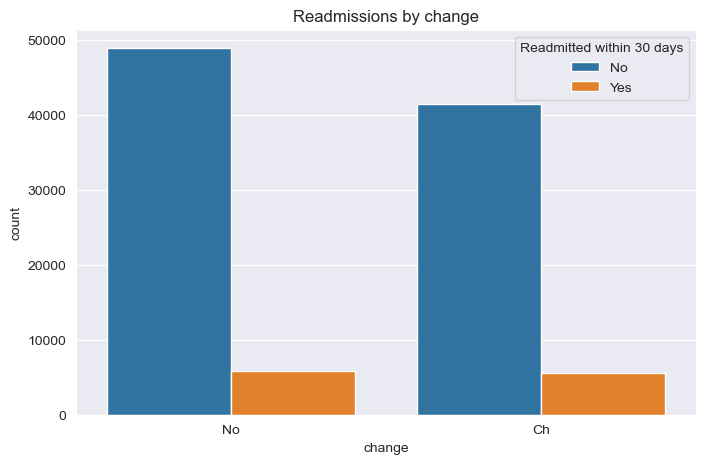

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'readmitted' is treated as categorical with 'Yes' and 'No'
df['readmitted'] = df['readmitted'].map({0: 'No', 1: 'Yes'})  # or use df['readmitted'].astype('category')

# List of columns to plot
cols = ['age', 'race', 'gender', 'number_diagnoses', 'time_in_hospital', 'A1Cresult', 'diabetesMed', 'change']

# Loop through columns to plot
for col in cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, hue='readmitted', data=df, order=df[col].unique())
    plt.title(f'Readmissions by {col}')
    plt.legend(title='Readmitted within 30 days', labels=('No', 'Yes'))
    plt.show()

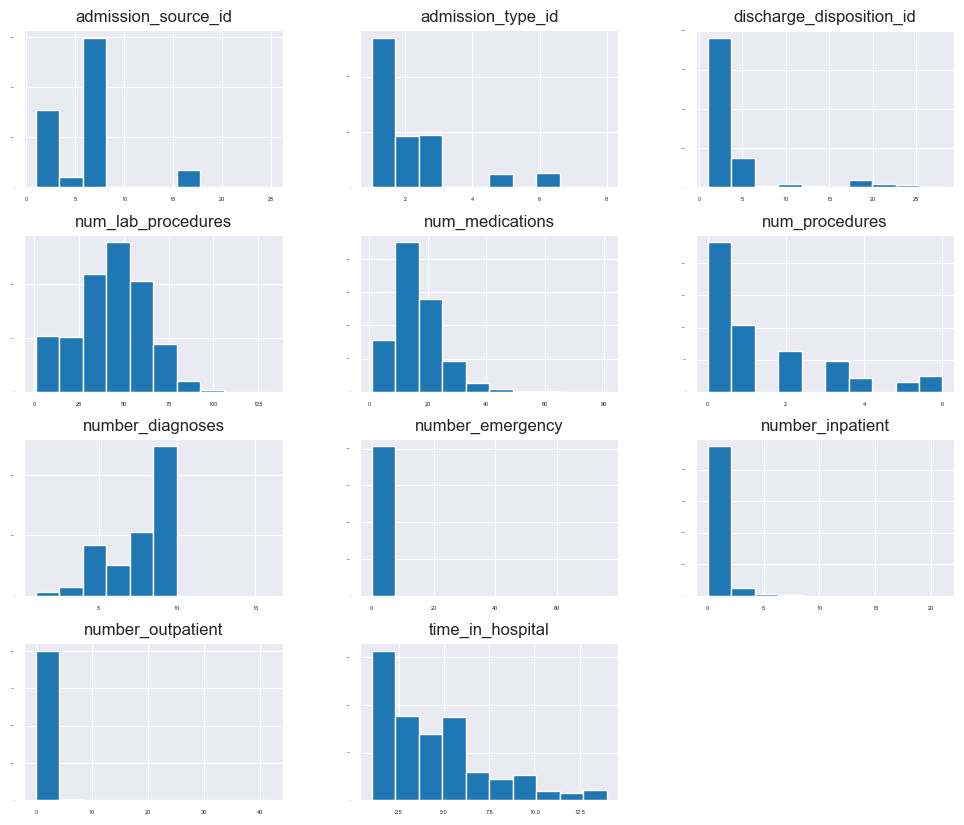

In [26]:
#Visualize the data distribution 
df[df.columns.difference(['encounter_id', 'patient_nbr'])].hist(sharex=False, sharey=False, xlabelsize=4, ylabelsize=1,figsize=(12, 10));

error check

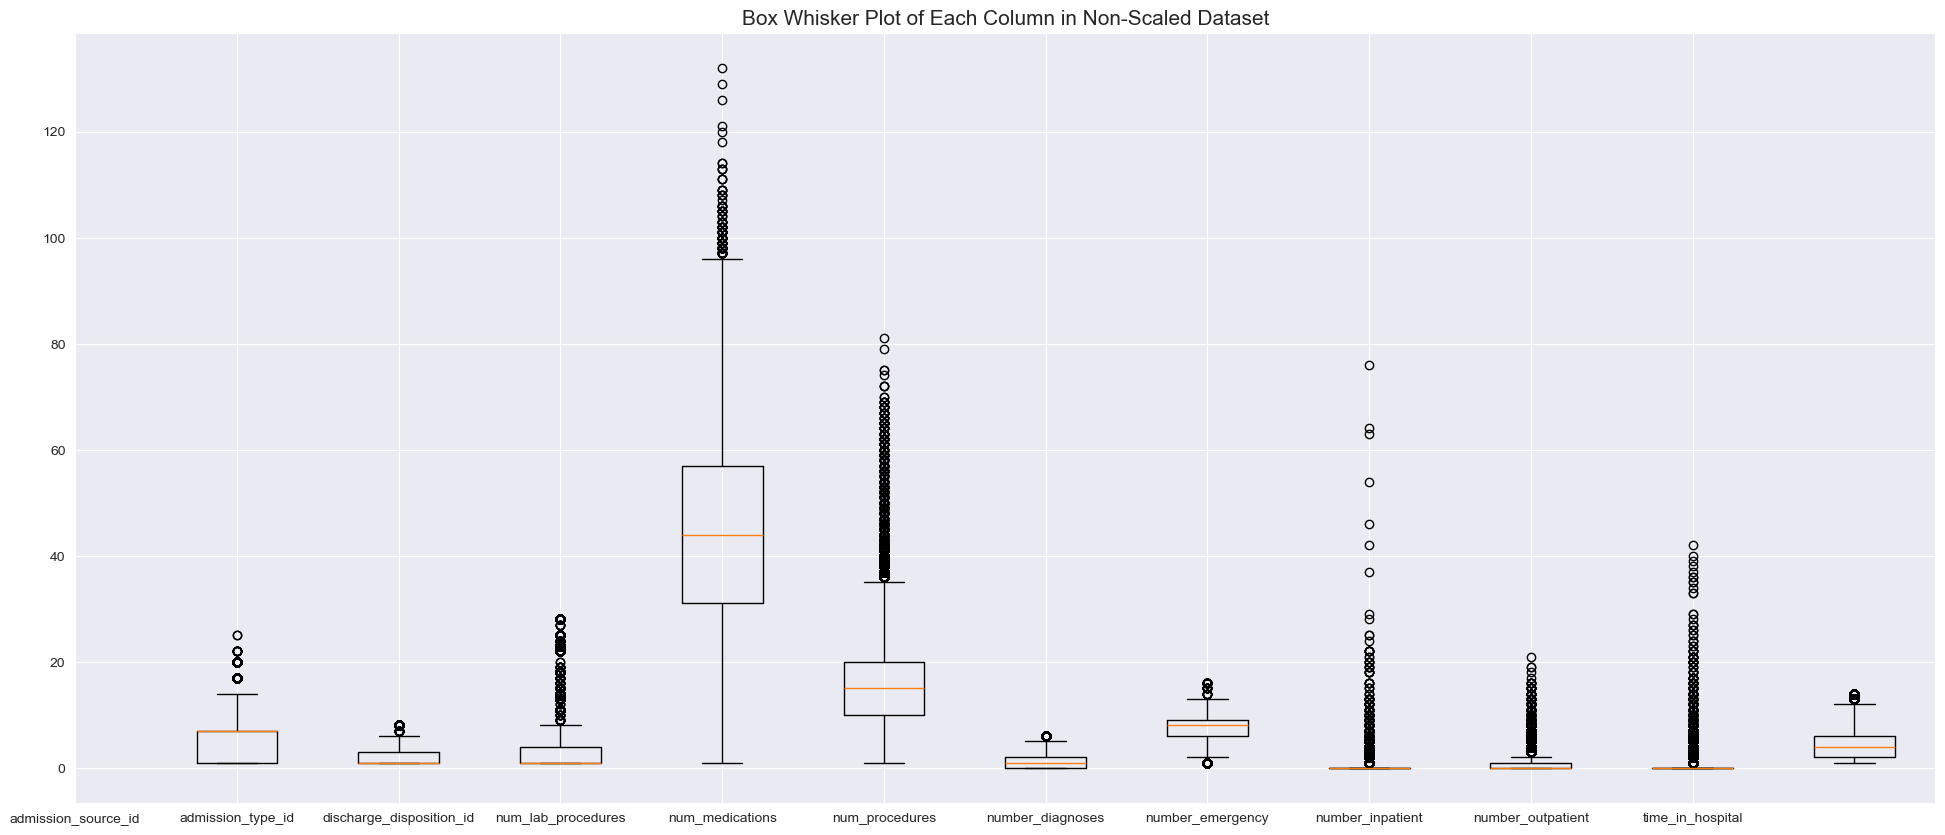

In [30]:
#Check the spread of values (standardize the data for modeling)
num_feat = df[df.columns.difference(['encounter_id', 'patient_nbr'])].select_dtypes(include=[np.number])
plt.figure(figsize=(24, 10))
plt.boxplot([num_feat[col] for col in num_feat.columns])
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(len(num_feat.columns.values)), num_feat.columns.values)
plt.show()

In [32]:
#Drop attributes with high percentage of Nulls. 
dfc = df.copy()
df.drop(['weight', 'payer_code', 'medical_specialty'],axis =1, inplace=True) 
df.shape

(101766, 47)

In [34]:
#delete attributes with same values (cardinality=1)
df.drop(['citoglipton', 'examide'], axis =1, inplace=True) 
df.shape

(101766, 45)

In [36]:
#drop rows with unknown gender
df = df[df.gender != 'Unknown/Invalid']
df.shape

(101763, 45)

In [38]:
print(df['discharge_disposition_id'].dtype)

int64


In [40]:
dcdisp = [11, 13, 14, 19, 20, 21]  # Keep as integers
df = df.loc[~df['discharge_disposition_id'].isin(dcdisp)]
print(df.shape)

(99340, 45)


In [42]:
# delete all rows with missing diagnosis
Dx = df[(df['diag_1'] == '?' ) | (df['diag_2'] == '?' ) | (df['diag_3'] == '?'  )].index
df.drop(Dx, inplace=True)
df.shape

(97822, 45)

In [44]:
# Change  ? race to 'Unknown'
df.replace({'race': {'?': 'Unknown'}}, inplace=True)

# Change admission type urgent and trauma into emergency
df['admission_type_id'].replace([2,7],1, inplace=True)     

# Change admission type Null and not mapped into not available (5)
df['admission_type_id'].replace([6,8],5, inplace=True)  

#Consolidate discharge disposition reason 
df['discharge_disposition_id'].replace([6, 8, 9],1, inplace=True)                                #Home
df['discharge_disposition_id'].replace([3, 4, 5, 15, 22, 23, 24, 27,30],2, inplace=True)         #Another facility
df['discharge_disposition_id'].replace([16, 17],12, inplace=True)                                #outpatient
df['discharge_disposition_id'].replace([25, 26],18, inplace=True)                                #null

#Consolidate admission source reason 
df['admission_source_id'].replace([2,3],1, inplace=True)                                     #Referral
df['admission_source_id'].replace([5, 6, 10, 18, 22, 25], 4, inplace=True)                   #transfer
df['admission_source_id'].replace([15, 17, 20, 21], 9, inplace=True)                         #not available
df['admission_source_id'].replace([12, 13, 14], 11, inplace=True)                            #delivery


In [46]:
#Get Systems for ICD9
def getICD(i):
    if 'V' in str(i) or 'E' in str(i):
        return 0
    i = float(i) 
    if (i >= 390 and i <= 459) or np.floor(i) == 785:
        return 1
    elif (i >= 460 and i <= 519) or np.floor(i) == 786:
        return 2
    elif (i >= 520 and i <= 579) or np.floor(i) == 787:
        return 3
    elif np.floor(i) == 250:
        return 4
    elif i >= 800 and i <= 999:
        return 5
    elif i >= 710 and i <= 739:
        return 6
    elif (i >= 580 and i <= 629) or np.floor(i) == 788:
        return 7
    elif i >= 140 and i <= 239:
        return 8
    else:
        return 0
    
#Get the ICD Categories for each ICD9. We will use only diag_1 as primary diagnosis    
df['ICDCat1'] = df['diag_1'].apply(lambda i: getICD(i))
#df['ICDCat2'] = df['diag_2'].apply(lambda i: getICD(i)).astype('object')
#df['ICDCat3'] = df['diag_3'].apply(lambda i: getICD(i)).astype('object')
df['ICDCat1'] = df['ICDCat1'].astype(int)
df[['diag_1','ICDCat1']].head(15).T


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
diag_1,276,648,8,197,414,414,428,398,434,250.7,157,428,428,518,999
ICDCat1,0,0,0,8,1,1,1,1,1,4,8,1,1,2,5


In [48]:
#Add all prior inpatient, emergency and outpatient encounters in a new variable
df['num_encounters'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [50]:
#Add a new variable by getting the total number of medication changes
meds = ['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

for m in meds:
    colname = str(m) + 'del'
    df[colname] = df[m].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

    df['number_changes'] = 0


for m in meds:
    colname = str(m) + 'del'
    df['number_changes'] = df['number_changes'] + df[colname]
    del df[colname]
df['number_changes'].value_counts()

number_changes
0    71214
1    25214
2     1282
3      107
4        5
Name: count, dtype: int64

In [52]:
#Add a new variable by getting the total number of meds used during the encounter
for col in meds:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1) 

df['number_meds'] = 0
for col in meds:
    df['number_meds'] = df['number_meds'] + df[col]
df['number_meds'].value_counts()

number_meds
1    45205
0    22311
2    21314
3     7616
4     1313
5       58
6        5
Name: count, dtype: int64

In [54]:
#Get the median of the age group to create a new numeric variable to see the effect of increasing age on readmission
#Rename age to age-group
df.rename(columns={"age": "age_group"}, inplace=True)

age_id = {'[0-10)':5, 
          '[10-20)':15, 
          '[20-30)':25, 
          '[30-40)':35, 
          '[40-50)':45, 
          '[50-60)':55,
          '[60-70)':65, 
          '[70-80)':75, 
          '[80-90)':85, 
          '[90-100)':95}
df['age'] = df.age_group.replace(age_id)


In [56]:

#Organize the Categorical Variables
df.replace({'gender': {'Male': 1, 'Female' : 0}}, inplace=True)
df.replace({'change': {'Ch': 1, 'No' : 0}}, inplace=True)
df.replace({'diabetesMed': {'Yes': 1, 'No' : 0}}, inplace=True)

df.replace({'A1Cresult': {'>7': 2, '>8': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)
df.replace({'max_glu_serum': {'>200': 2, '>300': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)



In [58]:
pd.options.display.max_columns = 50
display(df.head(), df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 97822 entries, 1 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              97822 non-null  int64  
 1   patient_nbr               97822 non-null  int64  
 2   race                      97822 non-null  object 
 3   gender                    97822 non-null  int64  
 4   age_group                 97822 non-null  object 
 5   admission_type_id         97822 non-null  int64  
 6   discharge_disposition_id  97822 non-null  int64  
 7   admission_source_id       97822 non-null  int64  
 8   time_in_hospital          97822 non-null  int64  
 9   num_lab_procedures        97822 non-null  int64  
 10  num_procedures            97822 non-null  int64  
 11  num_medications           97822 non-null  int64  
 12  number_outpatient         97822 non-null  int64  
 13  number_emergency          97822 non-null  int64  
 14  number_inp

,encounter_id,patient_nbr,race,gender,age_group,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ICDCat1,num_encounters,number_changes,number_meds,age
1,149190,55629189,Caucasian,0,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,0,1,1,15
2,64410,86047875,AfricanAmerican,0,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,No,0,3,0,1,25
3,500364,82442376,Caucasian,1,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,0,1,1,35
4,16680,42519267,Caucasian,1,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,8,0,0,2,45
5,35754,82637451,Caucasian,1,[50-60),1,1,1,3,31,6,16,0,0,0,414,411,250,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,No,1,0,0,1,55


None

(97822, 50)

In [60]:
#Change data type to object for categorical features
cat_feat = ['encounter_id', 'patient_nbr','gender','admission_source_id','admission_type_id','discharge_disposition_id','max_glu_serum','A1Cresult'
            ,'change', 'diabetesMed' , 'ICDCat1','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', \
          'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', \
          'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin',  \
          'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
df[cat_feat] = df[cat_feat].astype('object')


In [62]:

#creating a list of categorical and numeric columns names

categorical=df.select_dtypes(include=['object'])
numeric=df.select_dtypes(exclude=['object'])
 
#numeric_var=list(set(list(df.select_dtypes(exclude=['object'])-{'readmitted'})
print(categorical.columns.values)
print(numeric.columns.values)
numeric_vars = numeric.drop(['readmitted'], axis=1, errors='ignore')
numerics = numeric_vars.columns.tolist()

['encounter_id' 'patient_nbr' 'race' 'gender' 'age_group'
 'admission_type_id' 'discharge_disposition_id' 'admission_source_id'
 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum' 'A1Cresult' 'metformin'
 'repaglinide' 'nateglinide' 'chlorpropamide' 'glimepiride'
 'acetohexamide' 'glipizide' 'glyburide' 'tolbutamide' 'pioglitazone'
 'rosiglitazone' 'acarbose' 'miglitol' 'troglitazone' 'tolazamide'
 'insulin' 'glyburide-metformin' 'glipizide-metformin'
 'glimepiride-pioglitazone' 'metformin-rosiglitazone'
 'metformin-pioglitazone' 'change' 'diabetesMed' 'readmitted' 'ICDCat1']
['time_in_hospital' 'num_lab_procedures' 'num_procedures'
 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'number_diagnoses' 'num_encounters' 'number_changes'
 'number_meds' 'age']


In [64]:
#Let's check % of outliers https://www.kaggle.com/prasadperera/the-boston-housing-dataset
print('\n',"=================== Outliers =======================") 
for k, v in numeric.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print(" %s outliers = %.2f%%" % (k, perc))
#Let's check skewness & kurtosis        
print('\n',"===================Skewness & Kurtosis =======================")       

for col in numeric:    
    print (col, "Skew is:", numeric[col].skew(), "Kurtosis is:", numeric[col].kurtosis())


 =================== Outliers =======================
 time_in_hospital outliers = 3.60%
 num_lab_procedures outliers = 0.15%
 num_procedures outliers = 7.93%
 num_medications outliers = 3.33%
 number_outpatient outliers = 100.00%
 number_emergency outliers = 100.00%
 number_inpatient outliers = 6.90%
 number_diagnoses outliers = 0.06%
 num_encounters outliers = 6.40%
 number_changes outliers = 0.11%
 number_meds outliers = 1.41%
 age outliers = 2.08%

 ===================Skewness & Kurtosis =======================
time_in_hospital Skew is: 1.1317664085311465 Kurtosis is: 0.8582730881673455
num_lab_procedures Skew is: -0.24250501129092308 Kurtosis is: -0.250823765661782
num_procedures Skew is: 1.3104474629629455 Kurtosis is: 0.8391960506284928
num_medications Skew is: 1.3458559624681155 Kurtosis is: 3.5698100578576715
number_outpatient Skew is: 8.81340693404269 Kurtosis is: 147.9359520324741
number_emergency Skew is: 22.89253674859365 Kurtosis is: 1184.2901033784879
number_inpatient S

In [66]:
# Perform logarithmic transformation to reduce skewness and decrease variability of data

df['number_inpatient_log'] = np.log1p(df['number_inpatient'])
df['number_emergency_log']  = np.log1p(df['number_emergency'])
df['number_outpatient_log']  = np.log1p(df['number_outpatient'])
df['num_encounters_log']  = np.log1p(df['num_encounters'])

pd.options.display.max_columns = 60
df.head()

,encounter_id,patient_nbr,race,gender,age_group,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ICDCat1,num_encounters,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,number_outpatient_log,num_encounters_log
1,149190,55629189,Caucasian,0,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,0,1,1,15,0.000000,0.0,0.000000,0.000000
2,64410,86047875,AfricanAmerican,0,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,No,0,3,0,1,25,0.693147,0.0,1.098612,1.386294
3,500364,82442376,Caucasian,1,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,0,1,1,35,0.000000,0.0,0.000000,0.000000
4,16680,42519267,Caucasian,1,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,8,0,0,2,45,0.000000,0.0,0.000000,0.000000
5,35754,82637451,Caucasian,1,[50-60),1,1,1,3,31,6,16,0,0,0,414,411,250,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,No,1,0,0,1,55,0.000000,0.0,0.000000,0.000000


In [68]:
#Drop the original features before transformation
print(df.shape)
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','num_encounters'], axis = 1)
df.shape

(97822, 54)


(97822, 50)

In [70]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

In [72]:
dfcopy = df.copy(deep = True)

In [74]:
df = dfcopy.copy(deep = True)

In [76]:
#Check for duplicate encounters and remove
display(df.shape)
enc = df['encounter_id']
display(df[enc.isin(enc[enc.duplicated()])])

enc = df['encounter_id']
df[enc.duplicated()]

display(df.shape)

(97822, 47)

,encounter_id,patient_nbr,race,gender,age_group,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ICDCat1,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,number_outpatient_log,num_encounters_log


(97822, 47)

In [78]:
#Find duplicate patients and remove except for the first occurrence 

patients = df['patient_nbr']
df[patients.isin(patients[patients.duplicated()])]

df2 = df.loc[~df.patient_nbr.duplicated(keep='first')]
df2.shape

(68885, 47)

In [80]:
numeric=df2.select_dtypes(exclude=['object'])
 
numeric_vars = numeric.drop(['readmitted'], axis=1, errors='ignore')
numerics = numeric_vars.columns.tolist()

In [82]:
df2.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,number_outpatient_log,num_encounters_log
count,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000,68885.000000
mean,4.301227,42.955898,1.439167,15.774218,7.310576,0.262002,1.191348,65.793642,0.103550,0.061124,0.135318,0.271864
std,2.941826,19.919356,1.763318,8.276767,1.898289,0.476121,0.944245,15.572944,0.298941,0.230229,0.381502,0.506302
min,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,31.000000,0.000000,10.000000,6.000000,0.000000,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,44.000000,1.000000,14.000000,8.000000,0.000000,1.000000,65.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,9.000000,0.000000,2.000000,75.000000,0.000000,0.000000,0.000000,0.693147
max,14.000000,132.000000,6.000000,81.000000,16.000000,4.000000,6.000000,95.000000,2.564949,3.761200,3.761200,3.912023


In [84]:
# Remove outliers that are outside 3 standard deviation from either side of the mean (0.3%)
#Outlier prohibit the model to estimate the true relationship between variables by introducing bias.
print(df2.shape)
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]
df2.shape


(68885, 47)


(60535, 47)

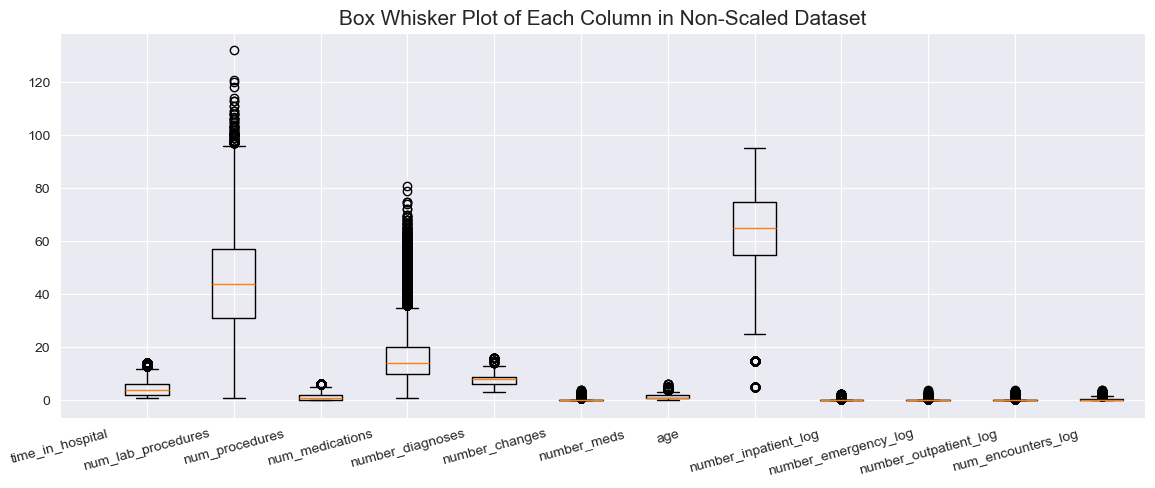

In [86]:
#Re-check the spread of values (standardize the data for modeling)
#num_feat = df[df.columns.difference(['encounter_id', 'patient_nbr'])].select_dtypes(include=[np.number])
plt.figure(figsize=(14, 5))
plt.boxplot([numeric[col] for col in numeric.columns])
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(len(numeric.columns.values)), numeric.columns.values, rotation = 15)
plt.show()

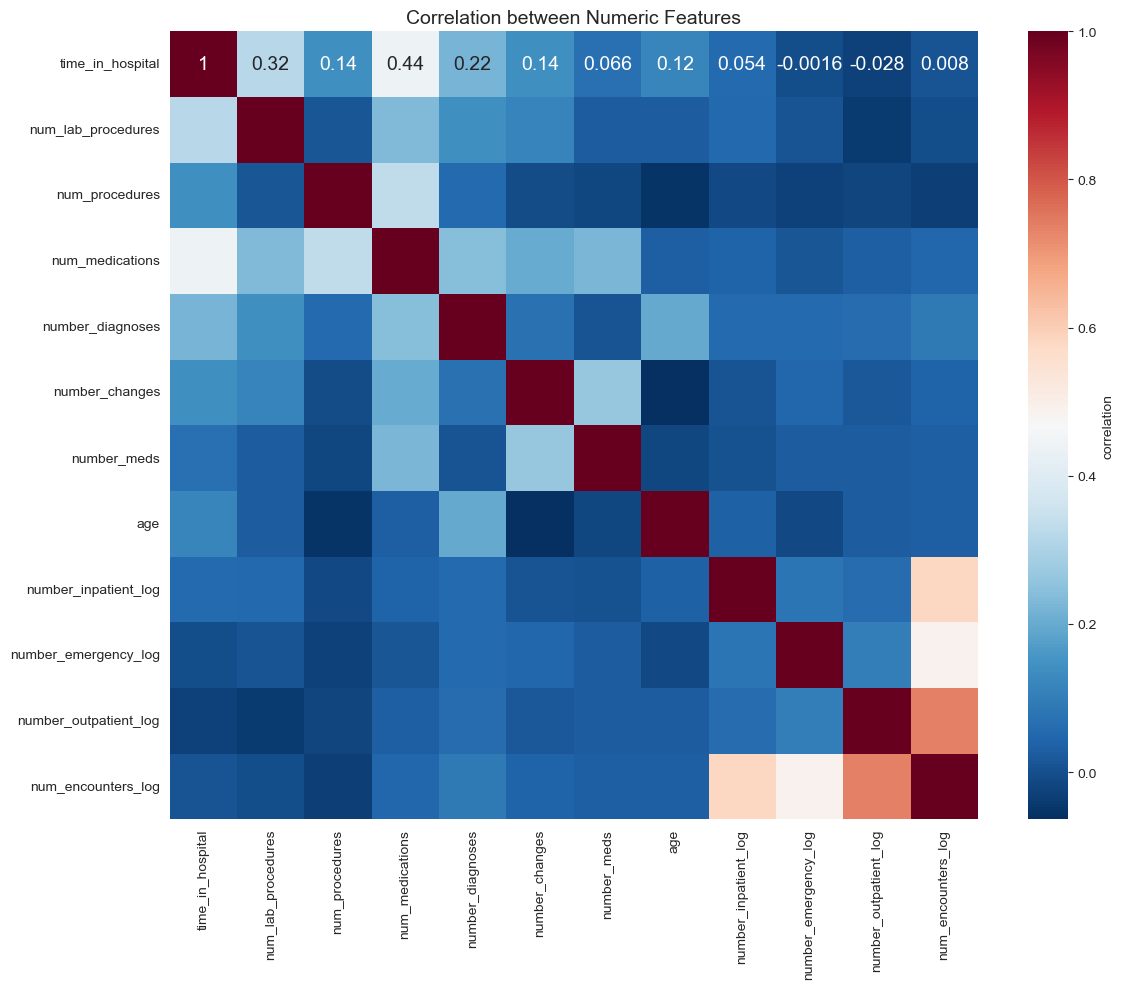

In [88]:
# Extract numeric columns
numeric = df2.select_dtypes(include=['number'])

# Now you can calculate the correlation and create the heatmap
plt.figure(figsize=(12,10))
sns.heatmap(numeric.corr(), cmap='RdBu_r', annot=True, annot_kws={'size': 14},
            cbar=True, cbar_kws={'label': 'correlation'})
plt.title('Correlation between Numeric Features', fontdict={'fontsize': 14})
plt.tight_layout()
plt.show()


In [90]:
df2.head(5)

,encounter_id,patient_nbr,race,gender,age_group,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ICDCat1,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,number_outpatient_log,num_encounters_log
2,64410,86047875,AfricanAmerican,0,[20-30),1,1,7,2,11,5,13,6,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,No,0,0,1,25,0.693147,0.0,1.098612,1.386294
3,500364,82442376,Caucasian,1,[30-40),1,1,7,2,44,1,16,7,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,1,1,35,0.000000,0.0,0.000000,0.000000
4,16680,42519267,Caucasian,1,[40-50),1,1,7,1,51,0,8,5,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,8,0,2,45,0.000000,0.0,0.000000,0.000000
5,35754,82637451,Caucasian,1,[50-60),1,1,1,3,31,6,16,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,No,1,0,1,55,0.000000,0.0,0.000000,0.000000
6,55842,84259809,Caucasian,1,[60-70),3,1,1,4,70,1,21,7,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,1,0,3,65,0.000000,0.0,0.000000,0.000000


In [92]:
df.head(5)

,encounter_id,patient_nbr,race,gender,age_group,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ICDCat1,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,number_outpatient_log,num_encounters_log
1,149190,55629189,Caucasian,0,[10-20),1,1,7,3,59,0,18,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,1,1,15,0.000000,0.0,0.000000,0.000000
2,64410,86047875,AfricanAmerican,0,[20-30),1,1,7,2,11,5,13,6,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,No,0,0,1,25,0.693147,0.0,1.098612,1.386294
3,500364,82442376,Caucasian,1,[30-40),1,1,7,2,44,1,16,7,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,1,1,35,0.000000,0.0,0.000000,0.000000
4,16680,42519267,Caucasian,1,[40-50),1,1,7,1,51,0,8,5,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,8,0,2,45,0.000000,0.0,0.000000,0.000000
5,35754,82637451,Caucasian,1,[50-60),1,1,1,3,31,6,16,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,No,1,0,1,55,0.000000,0.0,0.000000,0.000000


In [94]:
df2.shape

(60535, 47)

In [96]:
df.shape

(97822, 47)

In [98]:
df2.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age_group',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'ICDCat1', 'number_changes', 'number_meds', 'age',
       'number_inpatient_log', 'number_emergency_log', 'number_outpatient_log',
       'num_encounters_log'],
      dtype='object')

In [100]:
#We will drop one of independent variables that are highly correlated to each other. 
df2.drop(['number_outpatient_log'], axis=1, inplace=True)

In [102]:
#checking correlations to drop columns if needed
import pandas as pd

# Select only numeric columns
df2_numeric = df2.select_dtypes(include=['number', 'float', 'int'])

# Calculate correlation matrix
c = df2_numeric.corr().abs()

# Unstack the table
s = c.unstack()

# Sort the values in descending order
so = s.sort_values(ascending=False)

# Remove self-correlations (1.0)
so = so[so < 1]

# Display the most relevant part of the list
print(so.head(200))


num_encounters_log    number_inpatient_log    0.581748
number_inpatient_log  num_encounters_log      0.581748
num_encounters_log    number_emergency_log    0.490448
number_emergency_log  num_encounters_log      0.490448
time_in_hospital      num_medications         0.439897
                                                ...   
number_inpatient_log  number_meds             0.003784
number_emergency_log  time_in_hospital        0.001562
time_in_hospital      number_emergency_log    0.001562
num_encounters_log    num_lab_procedures      0.001539
num_lab_procedures    num_encounters_log      0.001539
Length: 110, dtype: float64


In [104]:
print(df2.shape)

data1=df2.copy(deep=True)
data1.to_csv('processed_predum_data.csv', index=False)
data1.head(5)

(60535, 46)


,encounter_id,patient_nbr,race,gender,age_group,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ICDCat1,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,num_encounters_log
2,64410,86047875,AfricanAmerican,0,[20-30),1,1,7,2,11,5,13,6,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,No,0,0,1,25,0.693147,0.0,1.386294
3,500364,82442376,Caucasian,1,[30-40),1,1,7,2,44,1,16,7,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,0,1,1,35,0.000000,0.0,0.000000
4,16680,42519267,Caucasian,1,[40-50),1,1,7,1,51,0,8,5,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,8,0,2,45,0.000000,0.0,0.000000
5,35754,82637451,Caucasian,1,[50-60),1,1,1,3,31,6,16,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,No,1,0,1,55,0.000000,0.0,0.000000
6,55842,84259809,Caucasian,1,[60-70),3,1,1,4,70,1,21,7,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,No,1,0,3,65,0.000000,0.0,0.000000


In [106]:

df = pd.get_dummies(df2, columns=['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult', 'ICDCat1', 'diabetesMed','change'], drop_first = True)
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60535 entries, 2 to 101765
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   encounter_id                 60535 non-null  object 
 1   patient_nbr                  60535 non-null  object 
 2   age_group                    60535 non-null  object 
 3   time_in_hospital             60535 non-null  int64  
 4   num_lab_procedures           60535 non-null  int64  
 5   num_procedures               60535 non-null  int64  
 6   num_medications              60535 non-null  int64  
 7   number_diagnoses             60535 non-null  int64  
 8   metformin                    60535 non-null  object 
 9   repaglinide                  60535 non-null  object 
 10  nateglinide                  60535 non-null  object 
 11  chlorpropamide               60535 non-null  object 
 12  glimepiride                  60535 non-null  object 
 13  acetohexamide       

In [108]:

pd.options.display.max_columns = 900
display(df.head())
df.info()


,encounter_id,patient_nbr,age_group,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,readmitted,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,num_encounters_log,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_1,admission_type_id_3,admission_type_id_4,admission_type_id_5,discharge_disposition_id_2,discharge_disposition_id_7,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_18,discharge_disposition_id_28,admission_source_id_4,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_11,max_glu_serum_2.0,A1Cresult_2.0,ICDCat1_1,ICDCat1_2,ICDCat1_3,ICDCat1_4,ICDCat1_5,ICDCat1_6,ICDCat1_7,ICDCat1_8,diabetesMed_1,change_1
2,64410,86047875,[20-30),2,11,5,13,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,0,1,25,0.693147,0.0,1.386294,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,500364,82442376,[30-40),2,44,1,16,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,1,1,35,0.000000,0.0,0.000000,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,16680,42519267,[40-50),1,51,0,8,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,0,2,45,0.000000,0.0,0.000000,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True
5,35754,82637451,[50-60),3,31,6,16,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,0,1,55,0.000000,0.0,0.000000,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
6,55842,84259809,[60-70),4,70,1,21,7,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,0,3,65,0.000000,0.0,0.000000,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True


<class 'pandas.core.frame.DataFrame'>
Index: 60535 entries, 2 to 101765
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   encounter_id                 60535 non-null  object 
 1   patient_nbr                  60535 non-null  object 
 2   age_group                    60535 non-null  object 
 3   time_in_hospital             60535 non-null  int64  
 4   num_lab_procedures           60535 non-null  int64  
 5   num_procedures               60535 non-null  int64  
 6   num_medications              60535 non-null  int64  
 7   number_diagnoses             60535 non-null  int64  
 8   metformin                    60535 non-null  object 
 9   repaglinide                  60535 non-null  object 
 10  nateglinide                  60535 non-null  object 
 11  chlorpropamide               60535 non-null  object 
 12  glimepiride                  60535 non-null  object 
 13  acetohexamide       

In [110]:
print(df.columns.tolist())


['encounter_id', 'patient_nbr', 'age_group', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'readmitted', 'number_changes', 'number_meds', 'age', 'number_inpatient_log', 'number_emergency_log', 'num_encounters_log', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'race_Unknown', 'gender_1', 'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5', 'discharge_disposition_id_2', 'discharge_disposition_id_7', 'discharge_disposition_id_10', 'discharge_disposition_id_12', 'discharge_disposition_id_18', 'discharge_disposition_id_28', 'admission_source_id_4', 'adm

In [112]:
predum = df.copy(deep=True)
predum.to_csv('dummy_readmit_data.csv', index=False)
#Drop columns that we no longer need for the model
drug_cols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide'\
                  ,'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone' \
                  ,'tolazamide','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',\
                  'metformin-rosiglitazone','metformin-pioglitazone']
for col in drug_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
df.shape

datafinal = df.copy(deep=True)
datafinal.to_csv('final_data1.csv', index=False)

In [113]:
datafinal

,encounter_id,patient_nbr,age_group,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,readmitted,number_changes,number_meds,age,number_inpatient_log,number_emergency_log,num_encounters_log,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_1,admission_type_id_3,admission_type_id_4,admission_type_id_5,discharge_disposition_id_2,discharge_disposition_id_7,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_18,discharge_disposition_id_28,admission_source_id_4,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_11,max_glu_serum_2.0,A1Cresult_2.0,ICDCat1_1,ICDCat1_2,ICDCat1_3,ICDCat1_4,ICDCat1_5,ICDCat1_6,ICDCat1_7,ICDCat1_8,diabetesMed_1,change_1
2,64410,86047875,[20-30),2,11,5,13,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,0,1,25,0.693147,0.000000,1.386294,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,500364,82442376,[30-40),2,44,1,16,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,1,1,35,0.000000,0.000000,0.000000,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,16680,42519267,[40-50),1,51,0,8,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,0,2,45,0.000000,0.000000,0.000000,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True
5,35754,82637451,[50-60),3,31,6,16,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,0,1,55,0.000000,0.000000,0.000000,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
6,55842,84259809,[60-70),4,70,1,21,7,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,0,3,65,0.000000,0.000000,0.000000,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101753,443841992,184875899,[40-50),13,51,2,13,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,1,2,45,0.000000,0.000000,0.000000,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True
101754,443842016,183087545,[70-80),9,50,2,33,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,No,1,2,75,0.000000,0.000000,0.000000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,True
101756,443842070,140199494,[60-70),2,46,6,17,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,0,1,65,0.693147,0.693147,1.386294,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
101758,443842340,120975314,[80-90),5,76,1,22,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,1,1,85,0.000000,0.693147,0.693147,False,True,False,False,False,False,False,False,False,False,False,False,False,F

In [116]:
X = datafinal.drop(['readmitted','age_group','encounter_id','patient_nbr'], axis=1)
y = datafinal['readmitted']

X.shape, y.shape

((60535, 64), (60535,))

In [118]:
from sklearn.preprocessing import LabelEncoder

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2,shuffle=True)

In [64]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

X_res.shape, y_res.shape

((88644, 64), (88644,))

In [65]:
scaler = StandardScaler()
training_scaled_features = scaler.fit_transform(X_res)
test_scaled_features = scaler.transform(X_test)

In [174]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [66]:
from sklearn.decomposition import PCA


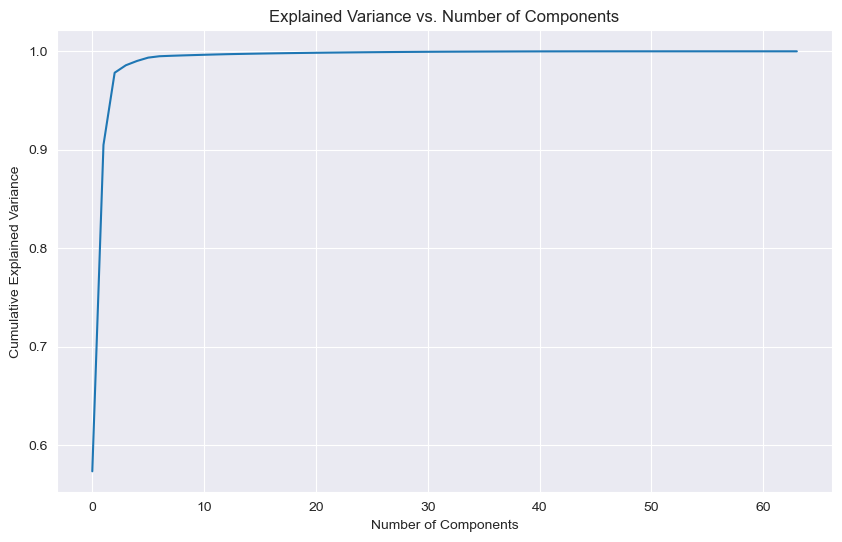

In [67]:

pca_full = PCA()
pca_full.fit(X_res)

cumulative_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [68]:
pca = PCA(n_components=10)
X_res_pca = pca.fit_transform(X_res)
X_test_pca = pca.transform(X_test)

exp_var_pca = pca.explained_variance_ratio_
exp_var_pca

array([5.73383792e-01, 3.31507503e-01, 7.33442649e-02, 7.59140176e-03,
       4.38427983e-03, 3.37824401e-03, 1.40301107e-03, 4.43780977e-04,
       3.75538467e-04, 3.41325724e-04])

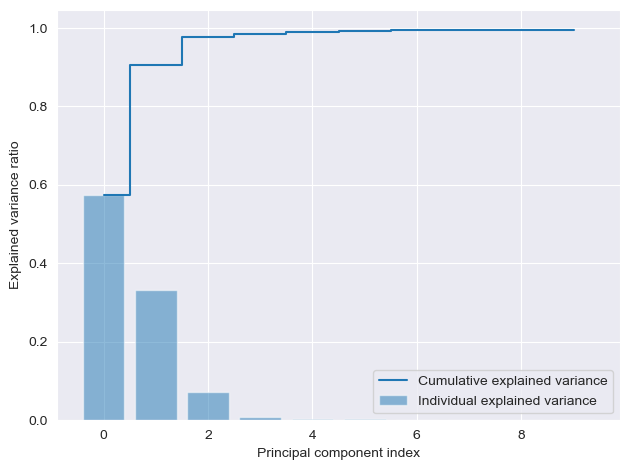

In [69]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [70]:
# Check the components (loadings) for your PCA
pca_components = pca.components_

# This will give you a matrix with the loadings for each principal component
print(pca_components)


[[ 4.93142428e-02  9.92750671e-01  4.57019457e-03  1.06211619e-01
   1.58645455e-02 -8.73238250e-04  9.82595603e-06 -2.49457348e-05
  -2.28381399e-06 -3.00219837e-05 -0.00000000e+00  1.08481814e-04
  -2.89666360e-05  1.62445279e-06 -1.08193468e-04 -7.89565217e-05
  -5.32151458e-06 -2.03223420e-06  1.27529272e-06 -3.57753979e-07
   2.45393190e-03 -4.29167653e-05 -1.34078551e-06 -0.00000000e+00
   2.34258823e-07 -5.60071003e-07  1.75925323e-03  1.10030101e-03
   1.88801042e-02  5.25533296e-04 -5.04555750e-05  5.43333777e-05
  -4.46583285e-05 -1.83962814e-04  2.98276554e-05  1.18582467e-06
   4.03704745e-05 -1.50385253e-04 -5.18978323e-03  2.04460731e-06
   4.23164384e-05  1.34387491e-03 -3.67486594e-05  2.57171585e-06
  -1.00255458e-05  1.11005170e-04  3.82513121e-05  3.00710671e-04
   5.71082744e-03 -8.90164969e-07 -1.32976524e-03 -5.90350565e-07
  -6.27965456e-04  4.52326434e-03  4.62828440e-04  2.31716159e-04
   8.66042429e-04  8.42792125e-04 -4.10045863e-04 -1.73488410e-03
   8.25097

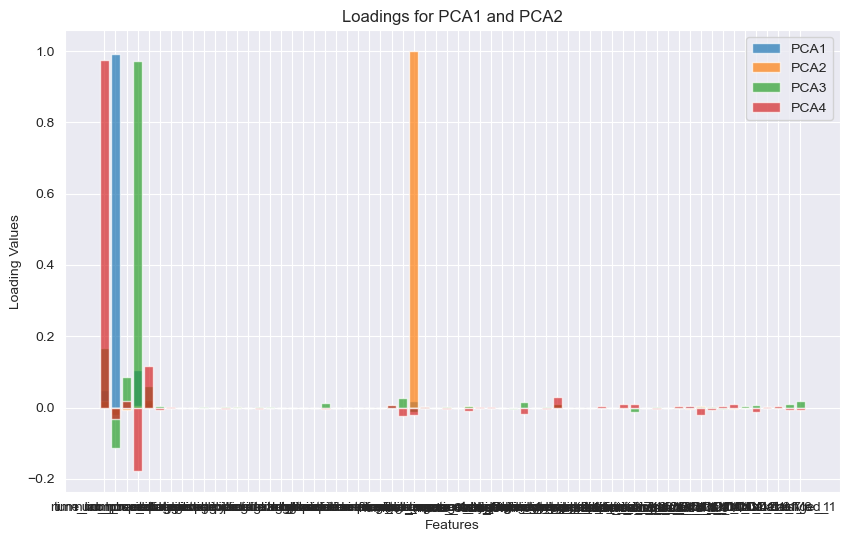

In [71]:
import matplotlib.pyplot as plt

# Feature names for interpretation
features = datafinal.drop(['readmitted','age_group','encounter_id','patient_nbr'], axis=1).columns.tolist()

# Plot the loadings for PCA1 and PCA2
plt.figure(figsize=(10, 6))
plt.bar(features, pca_components[0], alpha=0.7, label='PCA1')  # PCA1 loadings
plt.bar(features, pca_components[1], alpha=0.7, label='PCA2')  # PCA2 loadings
plt.bar(features, pca_components[2], alpha=0.7, label='PCA3')
plt.bar(features, pca_components[3], alpha=0.7, label='PCA4')
plt.legend()
plt.title("Loadings for PCA1 and PCA2")
plt.xlabel("Features")
plt.ylabel("Loading Values")
plt.show()


In [72]:
import pandas as pd

# Assuming 'pca' is your fitted PCA model and 'X' is your original feature matrix

# Get the PCA components (loadings)
pca_components = pca.components_  # Shape: (n_components, n_features)

# Features of your dataset
features = X.columns.tolist()

# Create a DataFrame to display the loadings for the first two PCA components
pca_loadings = pd.DataFrame(pca_components.T, columns=[f'PCA{i+1}' for i in range(pca.n_components)], index=features)

# Get the most important features for PCA1 and PCA2
top_pca1_features = pca_loadings['PCA1'].abs().sort_values(ascending=False)  # Absolute values for sorting by contribution
top_pca2_features = pca_loadings['PCA2'].abs().sort_values(ascending=False) 
top_pca3_features = pca_loadings['PCA3'].abs().sort_values(ascending=False)# Absolute values for sorting by contribution
top_pca4_features = pca_loadings['PCA4'].abs().sort_values(ascending=False)

# Display the top features for PCA1 and PCA2
print("Top features for PCA1:")
print(top_pca1_features)

print("\nTop features for PCA2:")
print(top_pca2_features)


print("\nTop features for PCA3:")
print(top_pca3_features)


print("\nTop features for PCA4:")
print(top_pca4_features)

Top features for PCA1:
num_lab_procedures             9.927507e-01
num_medications                1.062116e-01
time_in_hospital               4.931424e-02
age                            1.888010e-02
number_diagnoses               1.586455e-02
admission_source_id_7          5.710827e-03
admission_type_id_3            5.189783e-03
num_procedures                 4.570195e-03
A1Cresult_2.0                  4.523264e-03
insulin                        2.453932e-03
number_changes                 1.759253e-03
ICDCat1_6                      1.734884e-03
change_1                       1.610119e-03
discharge_disposition_id_2     1.343875e-03
admission_source_id_9          1.329765e-03
number_meds                    1.100301e-03
metformin                      8.732383e-04
ICDCat1_3                      8.660424e-04
ICDCat1_4                      8.427921e-04
ICDCat1_7                      8.250980e-04
diabetesMed_1                  6.958475e-04
max_glu_serum_2.0              6.279655e-04
number_in

In [176]:
features

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_diagnoses',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'number_changes',
 'number_meds',
 'age',
 'number_inpatient_log',
 'number_emergency_log',
 'num_encounters_log',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'race_Unknown',
 'gender_1',
 'admission_type_id_3',
 'admission_type_id_4',
 'admission_type_id_5',
 'discharge_disposition_id_2',
 'discharge_disposition_id_7',
 'discharge_disposition_id_10',
 'discharge_disposition_id_12',
 'discharge_disposition_id_18',
 'discharge_disposition_id_28',
 'admission_source_id_4',
 'admission_sou

In [73]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [74]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


In [75]:
# Split into train and test (if not already done)
X_train, X_test, y_train, y_test = train_test_split(X_res_pca, y_res, test_size=0.2, random_state=42)


In [76]:
# Define the LightGBM model
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', 
                                objective='binary', 
                                metric='binary_error', 
                                class_weight='balanced', 
                                n_estimators=1000, 
                                learning_rate=0.05)

# Fit the model
lgbm_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 35478, number of negative: 35437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 70915, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05,
               metric='binary_error', n_estimators=1000, objective='binary')

In [77]:
# Make predictions on the test set
y_pred = lgbm_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Optional: ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC: {roc_auc}")


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      8885
           1       0.87      0.85      0.86      8844

    accuracy                           0.86     17729
   macro avg       0.86      0.86      0.86     17729
weighted avg       0.86      0.86      0.86     17729

Confusion Matrix:
[[7787 1098]
 [1352 7492]]
Accuracy: 0.861808336623611
ROC AUC: 0.9318183981611359


In [78]:
import joblib

# Save the model
joblib.dump(lgbm_model, 'lightgbm_model.pkl')


['lightgbm_model.pkl']

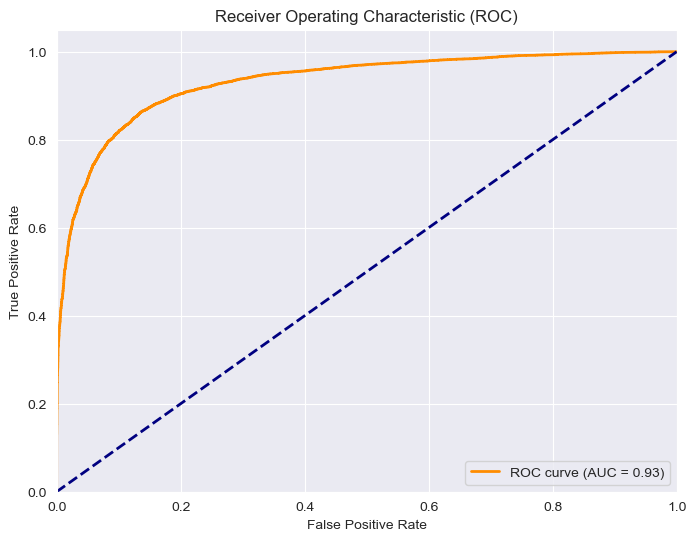

In [79]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, lgbm_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


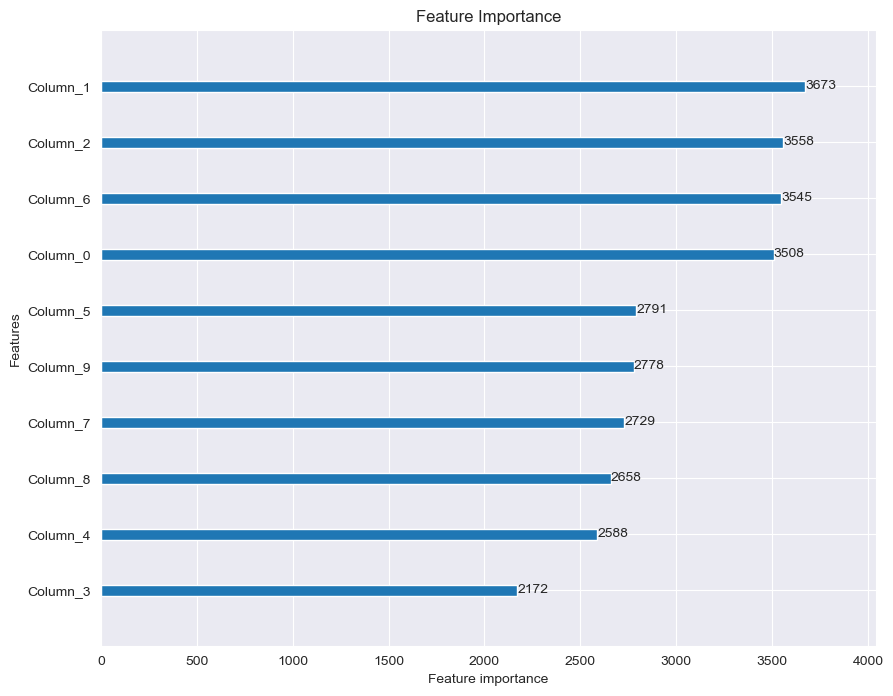

In [80]:
import lightgbm as lgb

# Plot feature importance
lgb.plot_importance(lgbm_model, max_num_features=20, importance_type='split', figsize=(10, 8))
plt.title('Feature Importance')
plt.show()


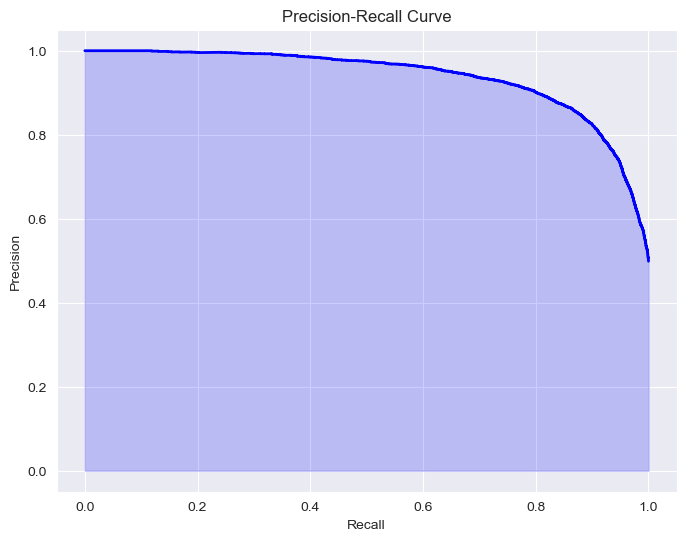

In [81]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, lgbm_model.predict_proba(X_test)[:, 1])

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [168]:
import joblib
joblib.dump(encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [182]:
joblib.dump(pca, 'pca1.pkl')

['pca1.pkl']

In [180]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']